In [1]:
import math
import numpy as np
from astropy.io.votable import parse_single_table
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import glob
from scipy import stats

import seaborn as sns
import pandas as pd

sns.set()
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
sns.set(style="darkgrid")
sns.set_context('paper')


## Catalogue statistics and plots

Calculate statistics based on the spectra catalogue.

### Table of Contents

* [Noise Statistics](#Noise-Statistics)
* [CDF of detections and non-detections](#CDF-of-detections-and-non-detections)
* [Plot of SMC absorption features by optical depth](#Plot-of-SMC-absorption-features-by-optical-depth)

### Noise Statistics


In [2]:
spec_tab = parse_single_table('gaskap_smc_spectra.vot').to_table()

In [3]:
min_flux = 0
max_fluxes = [20, 25, 30, 35, 40, 45, 55, 650]
noise_levels = []
for max_flux in max_fluxes:
    subset = (spec_tab['flux_peak'] > min_flux) & (spec_tab['flux_peak'] <= max_flux)
    targets = spec_tab[subset]
    fp_med = np.median(targets['sd_cont'])
    fp_mean = np.mean(targets['sd_cont'])
    min_opacity = 1- (fp_med*3)
    min_tau = 0 if min_opacity < 0 else -1*np.log(min_opacity)
    print ("Flux range {:.0f} to {:.0f} has median {:.4f} and mean {:.4f} 3-sigma opacity {:.3f} tau  {:.3f}  for {} records".format(
        min_flux, max_flux, fp_med, fp_mean, min_opacity, min_tau, len(targets)))
    noise_levels.append(targets['sd_cont'].filled().data)
    min_flux = max_flux

Flux range 0 to 20 has median 0.1680 and mean 0.1679 3-sigma opacity 0.496 tau  0.701  for 66 records
Flux range 20 to 25 has median 0.1435 and mean 0.1450 3-sigma opacity 0.570 tau  0.563  for 44 records
Flux range 25 to 30 has median 0.1170 and mean 0.1176 3-sigma opacity 0.649 tau  0.432  for 24 records
Flux range 30 to 35 has median 0.1054 and mean 0.1054 3-sigma opacity 0.684 tau  0.380  for 22 records
Flux range 35 to 40 has median 0.0932 and mean 0.1005 3-sigma opacity 0.721 tau  0.328  for 9 records
Flux range 40 to 45 has median 0.0818 and mean 0.0755 3-sigma opacity 0.755 tau  0.282  for 10 records
Flux range 45 to 55 has median 0.0579 and mean 0.0610 3-sigma opacity 0.826 tau  0.191  for 9 records
Flux range 55 to 650 has median 0.0370 and mean 0.0370 3-sigma opacity 0.889 tau  0.118  for 45 records


/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [4]:
min_tau_3s = -1*np.log(1- (spec_tab['sd_cont']*3))
min_tau_5s = -1*np.log(1- (spec_tab['sd_cont']*5))

/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_10402/2458286771.py:2: RuntimeWarning: invalid value encountered in log
  min_tau_5s = -1*np.log(1- (spec_tab['sd_cont']*5))


(array([ 3., 11., 10., 12., 13.,  8.,  2.,  4.,  2.,  1.]),
 array([0.01860518, 0.21093943, 0.40327368, 0.59560792, 0.78794217,
        0.98027642, 1.17261066, 1.36494491, 1.55727916, 1.74961341,
        1.94194765]),
 <BarContainer object of 10 artists>)

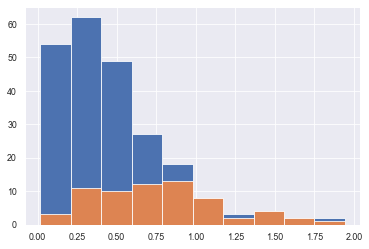

In [5]:
min_flux = 0
max_flux = 20
subset = (spec_tab['flux_peak'] <= max_flux)
values, bins, patches = plt.hist(min_tau_3s)
plt.hist(min_tau_3s[subset], bins=bins)

(array([ 6., 10., 10.,  9.,  1.,  4.,  3.,  1.,  1.,  0.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

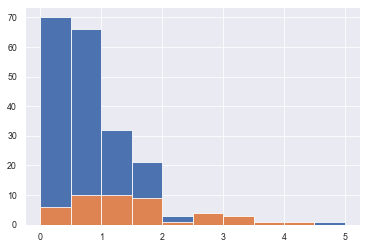

In [6]:
values, bins, patches = plt.hist(min_tau_5s, range=(0,5))
plt.hist(min_tau_5s[subset], bins=bins)

In [7]:
flux_bucket = np.zeros(len(spec_tab), dtype=int)
min_flux = 0
max_fluxes = [20, 25, 30, 40, 50, 650]
bin_size = []
bin_detections = []
bin_label = []

for flux in max_fluxes:
    subset = (spec_tab['flux_peak'] > min_flux) & (spec_tab['flux_peak'] <= flux)
    flux_bucket[subset] = flux
    bin_size.append(np.sum(subset))
    detections = spec_tab[subset]['has_other_abs']
    bin_detections.append(np.sum(detections))
    bin_label.append('>{:.0f}'.format(min_flux) if flux == max_fluxes[-1] else '{:.0f} - {:.0f}'.format(min_flux, flux))

    min_flux = flux

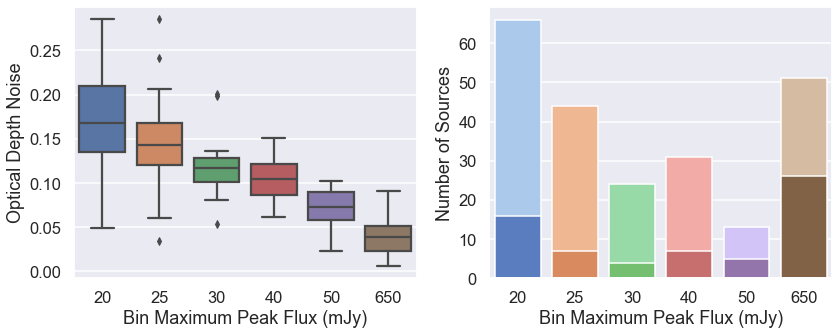

In [8]:
sns.set_context("talk")
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.boxplot(x=flux_bucket, y=spec_tab['sd_cont'], ax=axes[0])
axes[0].set_xlabel(r'Bin Maximum Peak Flux (mJy)')
axes[0].set_ylabel(r'Optical Depth Noise')

sns.barplot(x=max_fluxes, y=bin_size, ax=axes[1], palette='pastel', label='All')
sns.barplot(x=max_fluxes, y=bin_detections, ax=axes[1], palette='muted', label='Detections')
axes[1].set_xlabel(r'Bin Maximum Peak Flux (mJy)')
axes[1].set_ylabel(r'Number of Sources')

fig.set_tight_layout(True)
fig.savefig('figures/noise_by_peak_flux.png')

/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_10402/4196440224.py:4: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_10402/4196440224.py:4: MatplotlibDeprecationWarning: The 'subsx' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_10402/4196440224.py:5: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log', basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz690

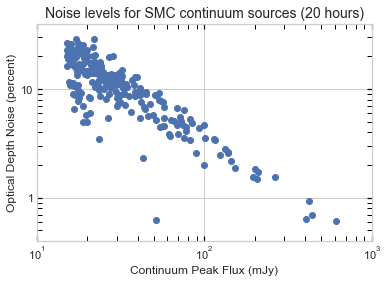

In [9]:
sns.set_context("talk")
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(1,1) #, figsize=(6.4, 4.8))
ax.set_xscale('log', basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_yscale('log', basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_yticklabels(labels=['', '', '1', '10'])
ax.scatter(spec_tab['flux_peak'], spec_tab['sd_cont']*100)
ax.set_xlabel('Continuum Peak Flux (mJy)', size=12)
ax.set_ylabel('Optical Depth Noise (percent)', size=12)
ax.set_xlim(10, 1000)
ax.set_ylim(0.4, 40)
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='black', length=5)
ax.set_title('Noise levels for SMC continuum sources (20 hours)', size=14)
fig.savefig('figures/flux-noise.png', bbox_inches='tight', dpi=200)
fig.savefig('figures/flux-noise.pdf', bbox_inches='tight')

/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_10402/1016386632.py:5: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_10402/1016386632.py:5: MatplotlibDeprecationWarning: The 'subsx' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_10402/1016386632.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=['', '', '1', '10'])


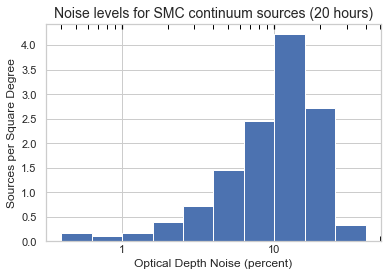

In [10]:
fig, ax = plt.subplots(1,1) #, figsize=(6.4, 4.8))

logbins = np.logspace(np.log10(0.4),np.log10(40),11)
ax.hist(spec_tab['sd_cont']*100, bins=logbins, weights=np.ones(len(spec_tab))*1/18)
ax.set_xscale('log', basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])

ax.set_xticklabels(labels=['', '', '1', '10'])
ax.tick_params(axis='x', which='both', direction='in', bottom=True, top=True, color='black', length=5)
ax.set_xlabel('Optical Depth Noise (percent)', size=12)
ax.set_ylabel('Sources per Square Degree', size=12)
ax.set_title('Noise levels for SMC continuum sources (20 hours)', size=14)


fig.savefig('figures/noise-src-count.png', bbox_inches='tight', dpi=200)
fig.savefig('figures/noise-src-count.pdf', bbox_inches='tight')



### CDF of detections and non-detections

In [11]:
df = spec_tab.to_pandas()

In [12]:
df

,id,comp_name,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,...,e_r_hi_high,e_r_hi_low,f_int,mean_ts,e_mean_ts_high,e_mean_ts_low,ew,e_ew_high,e_ew_low,num_chan
0,1,J004725-712727,11.855960,-71.457707,303.388557,-45.666985,B,15.015000,16.122000,0.000158,...,0.041169,0.033336,1.103011,49.663187,16.876208,9.727835,7.694376,2.303151,1.629697,40.0
1,5,J002620-743741,6.586833,-74.628167,305.179339,-42.390419,C,15.201000,17.952999,0.000142,...,0.054635,0.043649,1.107334,139.156804,90.931764,42.248207,12.730438,4.166417,2.974075,75.0
2,9,J011635-712604,19.148794,-71.434582,300.076822,-45.553951,C,15.333000,16.061001,0.000126,...,0.046907,0.035800,1.067695,146.734741,257.760456,66.124906,7.019581,3.306244,2.432056,85.0
3,10,J010425-742733,16.106350,-74.459193,301.749927,-42.639239,C,15.436000,16.305000,0.000114,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
4,13,J005535-723533,13.899411,-72.592574,302.495511,-44.532152,C,15.053000,31.764000,0.000085,...,0.050157,0.039817,1.175786,513.192983,213.118094,112.404060,15.701969,3.919882,2.706387,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,367,J005732-741243,14.384618,-74.212140,302.365433,-42.909400,A,439.358002,475.605011,0.003553,...,0.007484,0.007197,0.996999,251.678399,20.070510,19.996518,1.314694,0.059485,0.058319,48.0
225,368,J011050-731426,17.709450,-73.240658,300.995766,-43.814588,A,51.610001,160.432999,0.001398,...,0.001743,0.001753,1.094766,414.213140,8.033699,7.441010,7.670316,0.096277,0.096056,96.0
226,369,J011056-731407,17.735087,-73.235373,300.984810,-43.819071,A,100.070999,199.626007,0.000631,...,0.003875,0.003824,1.095078,349.713234,13.614913,13.869545,8.965557,0.318745,0.308300,97.0
227,370,J011049-731428,17.706215,-73.241230,300.997135,-43.814117,A,404.013000,456.187988,0.004489,...,0.001814,0.001694,1.096342,409.052656,7.154244,7.169105,7.751334,0.098779,0.095710,95.0


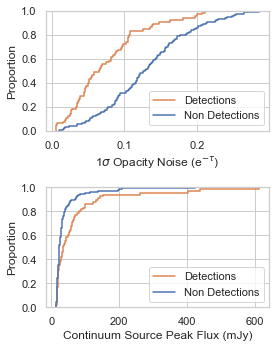

In [13]:
from matplotlib.legend import Legend

#fig, ax = plt.subplots(figsize=(6,4))
fig, ax = plt.subplots(2,1, figsize=(4,5))

ecdf = sns.ecdfplot(data=df, x="sd_cont", hue='has_other_abs', ax=ax[0], legend=False)
ax[0].set_xlabel(r'1$\sigma$ Opacity Noise (e$^{-\tau}$)')
ax[0].legend(['Detections', 'Non Detections'], loc='lower right')


sns.ecdfplot(data=df, x="flux_peak", hue='has_other_abs', ax=ax[1], legend=False)
ax[1].set_xlabel(r'Continuum Source Peak Flux (mJy)')
ax[1].legend(['Detections', 'Non Detections'])

fig.tight_layout()

plt.savefig('figures/spectra_by_peak_flux.png', bbox_inches='tight', dpi=200)

/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_10402/1457770041.py:10: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_10402/1457770041.py:10: MatplotlibDeprecationWarning: The 'subsx' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])


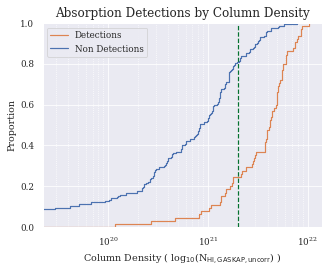

In [14]:
sns.set(style="darkgrid")
sns.set_context('paper')

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
fig, ax = plt.subplots(1,1, figsize=(5,3.75))

df['log_uncorr'] = np.log10(df['nh_uncorr'])
ecdf = sns.ecdfplot(data=df[df['sd_cont'] < 0.25], x="nh_uncorr", hue='has_other_abs', ax=ax, legend=False)
ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlabel(r'Column Density ( log$_{10}$(N$_{\rm HI,GASKAP,uncorr}$) )')
ax.vlines(2e21, 0, 1, colors=sns.color_palette('Greens_r')[0], ls='--', zorder=1)

plt.grid(True, which="major", ls="-")
plt.grid(True, which="minor", ls=":")

ax.set_title('Absorption Detections by Column Density', size=12)

plt.legend(['Detections', 'Non Detections'])
plt.savefig('figures/column_density_log.pdf', bbox_inches='tight')

/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_10402/1174776507.py:30: UserWarning: The handle <matplotlib.collections.LineCollection object at 0x7fbd419aed30> has a label of '_hidden' which cannot be automatically added to the legend.
  plt.legend(['_hidden', 'Detections', 'Non Detections'])


(0.0, 22.05)


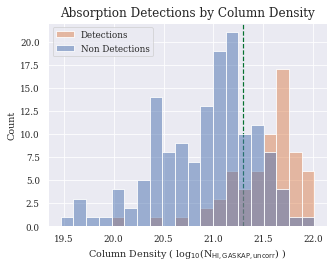

In [15]:
sns.set(style="darkgrid")
sns.set_context('paper')

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
#fig, ax = plt.subplots(1,1, figsize=(4.5,3))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))

df['log_uncorr'] = np.log10(df['nh_uncorr'])
#ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])

ecdf = sns.histplot(data=df[(df['sd_cont'] < 0.25) & (df['log_uncorr'] > 0)], x="log_uncorr", hue='has_other_abs', ax=ax, 
                    legend=False, bins=20)
#ecdf = sns.kdeplot(data=df[df['sd_cont'] < 0.25], x="nh_uncorr", hue='has_other_abs', ax=ax, legend=False, multiple="stack")
#ecdf = sns.kdeplot(data=df[df['sd_cont'] < 0.25], x="nh_uncorr", hue='has_other_abs', ax=ax, legend=False, multiple="stack")
print (ax.get_ylim())
curr_ylim = ax.get_ylim()
#ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlabel(r'Column Density ( log$_{10}$(N$_{\rm HI,GASKAP,uncorr}$) )')
ax.vlines(np.log10(2e21), 0, curr_ylim[1], colors=sns.color_palette('Greens_r')[0], ls='--', zorder=1)
ax.set_ylim(curr_ylim)
plt.grid(True, which="major", ls="-")
plt.grid(True, which="minor", ls=":")


#ax.xaxis.set_minor_locator(AutoMinorLocator())
#ax.tick_params(which='both', direction='in', bottom=True, top=True, color='w')
ax.set_title('Absorption Detections by Column Density', size=12)

plt.legend(['_hidden', 'Detections', 'Non Detections'])
plt.savefig('figures/column_density_log_hist.pdf', bbox_inches='tight')

### Plot of SMC absorption features by optical depth

In [16]:
abs_tab = parse_single_table('gaskap_smc_absorption.vot').to_table()
smc_abs_tab = abs_tab[abs_tab['start_vel']> 50]

In [17]:
abs_df = abs_tab.to_pandas()
smc_abs_df = smc_abs_tab.to_pandas()
smc_abs_df

,id,comp_name,abs_name,ra,dec,rating,flux_peak,mean_cont,sd_cont,opacity_range,...,start_vel,end_vel,length,min_optical_depth,e_min_optical_depth,peak_tau,e_peak_tau,max_sigma,ew,e_ew
0,13,J005535-723533,J005535-723533_113,13.899411,-72.592574,C,15.053000,0.000085,0.162273,1.856299,...,113.615978,114.615978,2,-0.332693,0.251391,5.000000,3.619253,5.301279,5.976204,0.416023
1,13,J005535-723533,J005535-723533_116,13.899411,-72.592574,C,15.053000,0.000085,0.162273,1.856299,...,116.615978,117.615978,2,-0.067383,0.270182,5.000000,3.691341,3.950607,2.832027,0.449841
2,19,J005448-725353,J005448-725353_116,13.702572,-72.898137,C,15.988000,0.000155,0.180708,2.211228,...,116.777136,118.777136,3,-0.122017,0.310779,5.000000,3.831327,3.610335,7.673108,0.632355
3,19,J005448-725353,J005448-725353_163,13.702572,-72.898137,C,15.988000,0.000155,0.180708,2.211228,...,163.777136,167.777136,5,-0.476034,0.307786,5.000000,3.821651,4.795642,11.323502,0.821009
4,26,J010532-721331,J010532-721331_131,16.386939,-72.225495,C,16.306000,0.000134,0.206259,1.732353,...,131.318491,133.318491,3,-0.032339,0.244997,5.000000,3.593490,4.213683,5.079844,0.487221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,370,J011049-731428,J011049-731428_135,17.706215,-73.241230,A,404.013000,0.004489,0.006336,0.498258,...,135.777646,148.777646,14,0.831592,0.008249,0.184414,0.009871,20.415632,1.198296,0.031650
115,370,J011049-731428,J011049-731428_150,17.706215,-73.241230,A,404.013000,0.004489,0.006336,0.498258,...,150.777646,168.777646,19,0.540591,0.009988,0.615092,0.018307,45.997348,5.938691,0.043197
116,370,J011049-731428,J011049-731428_172,17.706215,-73.241230,A,404.013000,0.004489,0.006336,0.498258,...,172.777646,175.777646,4,0.949157,0.009357,0.052181,0.009810,5.433862,0.166646,0.018639
117,370,J011049-731428,J011049-731428_177,17.706215,-73.241230,A,404.013000,0.004489,0.006336,0.498258,...,177.777646,178.777646,2,0.958851,0.008615,0.042020,0.008945,4.776406,0.078371,0.012325


In [18]:
min_opacity = np.maximum(smc_abs_tab['sd_cont'], smc_abs_tab['min_optical_depth'])

In [19]:
#num_samples = 40 # -100 to -60
capped_min_od = min_opacity
capped_min_od[capped_min_od < 0] = 0
tau = -1* np.log(capped_min_od)
tau[capped_min_od==0] = 5
tau_nan = np.nan_to_num(tau, nan=5)
min_od_noise = capped_min_od-smc_abs_tab['sd_cont']
filt = min_od_noise < 0
min_od_noise[filt] = capped_min_od[filt]+smc_abs_tab['sd_cont'][filt]
tau_nan_max = -1* np.log(min_od_noise)
tau_uncert = np.abs(smc_abs_tab['sd_cont'] / capped_min_od)
tau_uncert_calc = np.abs(tau_nan_max - tau_nan)
tau_uncert_plus = np.abs(tau_nan_max - tau_nan)
tau_uncert_minus = np.abs(tau_nan_max - tau_nan)
tau_uncert_calc

#tau_uncert
for idx, e_tau in enumerate(tau_uncert):
    if tau_nan[idx] > 2 and min_opacity[idx] > 0:
        print ("od={:.3f} +- {:.3f} tau={:.2f} +- {:.2f} or {:.2f}".format(
            min_opacity[idx], smc_abs_tab['sd_cont'][idx], tau_nan[idx], e_tau, tau_uncert_calc[idx]))

od=0.078 +- 0.078 tau=2.55 +- 1.00 or --
od=0.085 +- 0.085 tau=2.47 +- 1.00 or --
od=0.082 +- 0.082 tau=2.50 +- 1.00 or --
od=0.132 +- 0.105 tau=2.03 +- 0.80 or 1.59
od=0.105 +- 0.105 tau=2.26 +- 1.00 or --
od=0.125 +- 0.125 tau=2.08 +- 1.00 or --
od=0.087 +- 0.087 tau=2.44 +- 1.00 or --
od=0.068 +- 0.068 tau=2.69 +- 1.00 or --
od=0.066 +- 0.066 tau=2.72 +- 1.00 or --
od=0.070 +- 0.070 tau=2.66 +- 1.00 or --
od=0.078 +- 0.055 tau=2.55 +- 0.70 or 1.22
od=0.051 +- 0.051 tau=2.98 +- 1.00 or --
od=0.047 +- 0.047 tau=3.06 +- 1.00 or --
od=0.039 +- 0.035 tau=3.26 +- 0.92 or 2.48
od=0.025 +- 0.025 tau=3.70 +- 1.00 or --
od=0.022 +- 0.022 tau=3.82 +- 1.00 or --


/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_10402/84489711.py:10: RuntimeWarning: divide by zero encountered in log
  tau_nan_max = -1* np.log(min_od_noise)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_10402/84489711.py:20: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  print ("od={:.3f} +- {:.3f} tau={:.2f} +- {:.2f} or {:.2f}".format(


/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_10402/1021972020.py:45: RuntimeWarning: divide by zero encountered in log
  ax.plot(noise_range, -1* np.log(noise_range), color=sns.color_palette()[2], label="Noise limit")


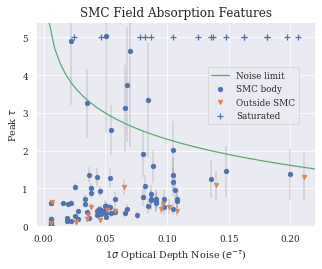

In [20]:
sns.set(style="darkgrid")
sns.set_context('paper')

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

#fig, ax = plt.subplots(1,1, figsize=(4.5,3))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))


e_tau = smc_abs_tab['e_peak_tau']

min_opacity = np.asarray(smc_abs_tab['min_optical_depth'])
opacity_filter = min_opacity > 0
tau = smc_abs_tab['peak_tau'][opacity_filter]

noise = smc_abs_tab['sd_cont'][opacity_filter]
e_tau_non_sat = e_tau[opacity_filter]
non_smc_body_abs = np.asarray(spec_tab['comp_name'][spec_tab['has_other_abs'] & (spec_tab['nh_uncorr'] < 2e21)])
non_smc_body_filter = np.isin(smc_abs_tab['comp_name'][opacity_filter], non_smc_body_abs)



plt.errorbar(noise[~non_smc_body_filter], tau[~non_smc_body_filter], yerr=e_tau_non_sat[~non_smc_body_filter], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(noise[~non_smc_body_filter], tau[~non_smc_body_filter], c='C0', s=20, label="SMC body")


plt.errorbar(noise[non_smc_body_filter], tau[non_smc_body_filter], yerr=e_tau_non_sat[non_smc_body_filter], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(noise[non_smc_body_filter], tau[non_smc_body_filter], color=sns.color_palette()[1], marker='v', s=20, label="Outside SMC")


full_non_smc_body_filter = np.isin(smc_abs_tab['comp_name'], non_smc_body_abs)
filt = ~opacity_filter & full_non_smc_body_filter
saturated = np.ones((np.sum(filt)))*5
ax.scatter(smc_abs_tab['sd_cont'][filt], saturated, color=sns.color_palette()[1], marker='+', s=40)
#plt.errorbar(saturated, smc_abs_tab['sd_cont'][filt], xerr=e_tau[filt], color=sns.color_palette()[1], fmt="+", alpha=0.6, ls=':')

filt = ~opacity_filter & ~full_non_smc_body_filter
saturated = np.ones((np.sum(filt)))*5
ax.scatter(smc_abs_tab['sd_cont'][filt], saturated, color=sns.color_palette()[0], marker='+', s=40, label="Saturated")
#plt.errorbar(saturated, smc_abs_tab['sd_cont'][filt], xerr=e_tau[filt], color=sns.color_palette()[0], fmt="+", alpha=0.6, ls=':')


noise_range = np.linspace(0, 0.22)
ax.plot(noise_range, -1* np.log(noise_range), color=sns.color_palette()[2], label="Noise limit")
ax.set_ylabel(r'Peak $\tau$')
ax.set_xlabel(r'1$\sigma$ Optical Depth Noise ($e^{-\tau}$)')
ax.set_ylim(0,5.4)
ax.set_xlim(-0.006,0.22)


ax.legend(loc='upper left', bbox_to_anchor=(0.6, 0.8))
#ax.legend(loc='upper right')
ax.set_title('SMC Field Absorption Features', size=12)


plt.savefig('figures/optical_depth.pdf', bbox_inches='tight')

plt.savefig('figures/optical_depth.png', bbox_inches='tight', dpi=200)





In [21]:
in_noise_filter = (smc_abs_tab['min_optical_depth'] < smc_abs_tab['sd_cont']) & opacity_filter
num_in_noise = np.sum(in_noise_filter)
smc_good_tau = -1* np.log(min_opacity[~in_noise_filter &opacity_filter])

print ("Num features {}, num saturated {}, num in the noise {}".format(len(smc_abs_tab), np.sum(~opacity_filter), num_in_noise))
print ("Of the {} good tau, min {:.2f}, med {:.2f} max {:.2f}".format(len(smc_good_tau), np.min(smc_good_tau), np.median(smc_good_tau), np.max(smc_good_tau)))

Num features 119, num saturated 16, num in the noise 6
Of the 97 good tau, min 0.04, med 0.50 max 3.26


In [22]:
non_smc_body_tau = -1* np.log(min_opacity[~in_noise_filter &opacity_filter & full_non_smc_body_filter])
print ("Of the {} non SMC body tau, min {:.2f}, med {:.2f} max {:.2f}".format(
    len(non_smc_body_tau), np.min(non_smc_body_tau), np.median(non_smc_body_tau), np.max(non_smc_body_tau)))

Of the 17 non SMC body tau, min 0.09, med 0.42 max 1.30


In [23]:
smc_body_tau = -1* np.log(min_opacity[~in_noise_filter &opacity_filter & ~full_non_smc_body_filter])
print ("Of the {} SMC body tau, min {:.2f}, med {:.2f} max {:.2f}".format(
    len(smc_body_tau), np.min(smc_body_tau), np.median(smc_body_tau), np.max(smc_body_tau)))

Of the 80 SMC body tau, min 0.04, med 0.52 max 3.26


In [24]:
# Detection rates by flux band
prev_cap = 0
print ('min  max num det   pct')
for cap in [30, 50, 10000]:
    src_filter = (spec_tab['flux_peak'] >= prev_cap) & (spec_tab['flux_peak'] < cap) & (spec_tab['nh_uncorr'] >= 2e21)
    num_spec = np.sum(src_filter)
    num_det = np.sum(spec_tab['has_other_abs'][src_filter])
    print ("{:2.0f} {:5d} {:3d} {:3d} {:5.1f}%".format(prev_cap, cap, num_spec, num_det, num_det/num_spec*100))
    prev_cap = cap

min  max num det   pct
 0    30  49  22  44.9%
30    50  11   8  72.7%
50 10000  19  19 100.0%


In [25]:
df1 = smc_abs_df.groupby('comp_name')['abs_name'].agg(['count']).reset_index()
df1.sort_values('comp_name')

,comp_name,count
0,J003037-742901,1
1,J003037-742903,1
2,J003242-733153,1
3,J003414-733329,1
4,J003809-735024,2
...,...,...
60,J012924-733153,1
61,J013134-700042,1
62,J013218-715348,1
63,J013701-730415,1


In [26]:
print ("Of {} spectra, {} have multiple features".format(len(df1), np.sum(df1['count'] > 1)))

Of 65 spectra, 36 have multiple features


In [27]:
df2 = df1[np.isin(df1['comp_name'], non_smc_body_abs)]
print ("Of {} non SMC body spectra, {} have multiple features".format(len(df2), np.sum(df2['count'] > 1)))

Of 16 non SMC body spectra, 1 have multiple features
